In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

# Import all surface reparametrization functions
from deepshape.surfaces import *


# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# Create example surface with 3 coordinate functions
f = Surface((
    lambda x: x[..., 0],
    lambda x: x[..., 1],
    lambda x: x[..., 0]**2 - x[..., 1]**2
))


# Helper function to create example Diffeomorphism
def angle(x):
    return 0.5 * np.pi * torch.sin(np.pi * x[..., 0]) * torch.sin(np.pi * x[..., 1])

# Example Diffeomorphism
γ = Diffeomorphism(
    (
        lambda x: (x[..., 0] - 0.5) * torch.cos(angle(x)) - (x[..., 1] - 0.5) * torch.sin(angle(x)) + 0.5,
        lambda x: (x[..., 0] - 0.5) * torch.sin(angle(x)) + (x[..., 1] - 0.5) * torch.cos(angle(x)) + 0.5
))


# Reparametrize f to get target surface g
g = f.compose(γ)


# Get q-maps of the two surfaces
q = Qmap(g)
r = Qmap(f)

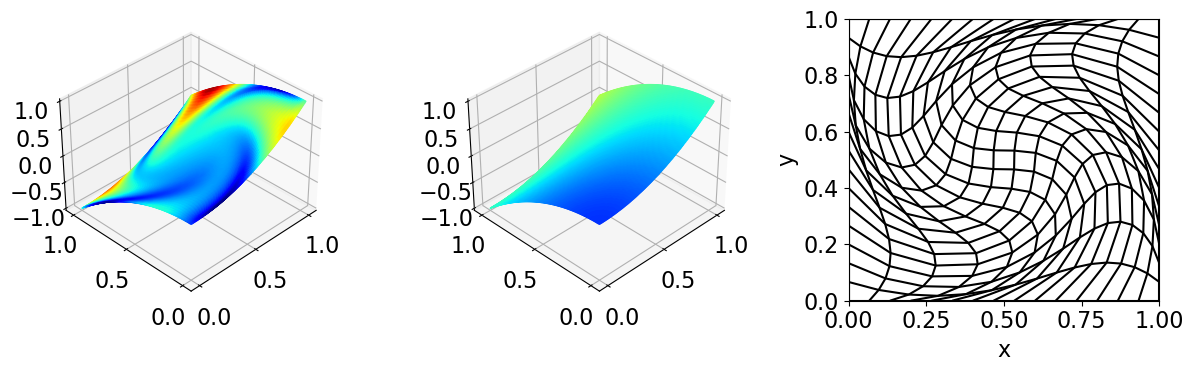

In [4]:
# Create Coloring Functions for plotting
k = 100 # Points per dimension (k^2 points total)
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()
norm = colors.Normalize(vmin=min(fcolors.min(), gcolors.min()), vmax=max(fcolors.max(), gcolors.max()))

# Init Figure 
fig = plt.figure(figsize=(12, 4))

# Plot Target surface g
Zg = get_plot_data(g, k=k)
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(*Zg, shade=False, facecolors=cm.jet(norm(gcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)

# Plot Inital surface f 
Z = get_plot_data(f, k=k)
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)

# Plot Target Reparametrization function
ax = fig.add_subplot(133)
plot_diffeomorphism(γ, k=16, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
# plt.show()

In [5]:
# Define reparametrization-network
RN = ReparametrizationNetwork2D(3, 10, layer_type=PalaisLayer)

# Define optimizer and learning rate scheduler
bfgs_iter = 100
optimizer = optim.LBFGS(RN.parameters(), lr=0.9, max_iter=bfgs_iter, max_eval=bfgs_iter, line_search_fn="strong_wolfe")
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=0.,
                                                 threshold_mode='rel', cooldown=10, min_lr=1e-3, eps=1e-08, verbose=True)

# Train and store convergence
errors = train_bfgs(q, r, RN, optimizer, iterations=1, scheduler=scheduler)

Iteration i
[Iter     0] loss: 0.25796583
[Iter     1] loss: 0.08155148
[Iter     2] loss: 0.03702590
[Iter     3] loss: 0.02467253
[Iter     4] loss: 0.01587438
[Iter     5] loss: 0.00676582
[Iter     6] loss: 0.00469918
[Iter     7] loss: 0.00299174
[Iter     8] loss: 0.00249107
[Iter     9] loss: 0.00208371
[Iter    10] loss: 0.00167391
[Iter    11] loss: 0.00141731
[Iter    12] loss: 0.00129587
[Iter    13] loss: 0.00116241
[Iter    14] loss: 0.00102140
[Iter    15] loss: 0.00093563
[Iter    16] loss: 0.00085963
[Iter    17] loss: 0.00081230
[Iter    18] loss: 0.00076964
[Iter    19] loss: 0.00069185
[Iter    20] loss: 0.00072875
[Iter    21] loss: 0.00066127
[Iter    22] loss: 0.00062473
[Iter    23] loss: 0.00059337
[Iter    24] loss: 0.00056154
[Iter    25] loss: 0.00052012
[Iter    26] loss: 0.00049564
[Iter    27] loss: 0.00047023
[Iter    28] loss: 0.00045505
[Iter    29] loss: 0.00044032
[Iter    30] loss: 0.00041927
[Iter    31] loss: 0.00039748
[Iter    32] loss: 0.0003828

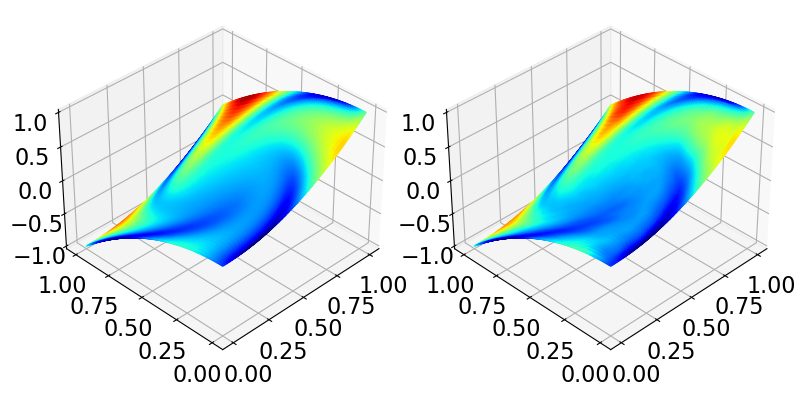

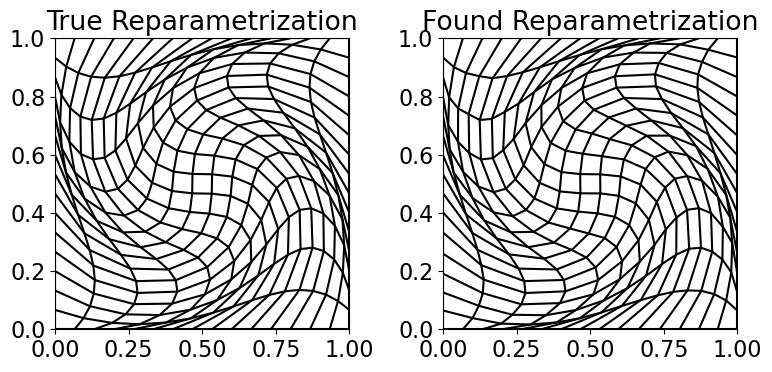

In [6]:
# Get diffeomorphism
u = lambda x: RN(x)[0]

# Reparametrize f
fafter = f.compose(u)

# Get coloring scheme for reparametrized surface
fafcolors = get_plot_data(fafter.volume_factor, k=k).squeeze()

# Get plotting data for reparametrized surface
Z = get_plot_data(fafter, k=k)

# Init Figure 
fig = plt.figure(figsize=(8, 4))

# Plot Target surface g
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(*Zg, shade=False, facecolors=cm.jet(norm(gcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)

# Plot Inital surface f 
Z = get_plot_data(fafter, k=k)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fafcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(8, 4))
# Plot Reparametrization function
ax = fig.add_subplot(121)
plot_diffeomorphism(γ, k=16, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("True Reparametrization")

# Plot Reparametrization function
ax = fig.add_subplot(122)
plot_diffeomorphism(u, k=16, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Found Reparametrization")

plt.tight_layout()
plt.show()

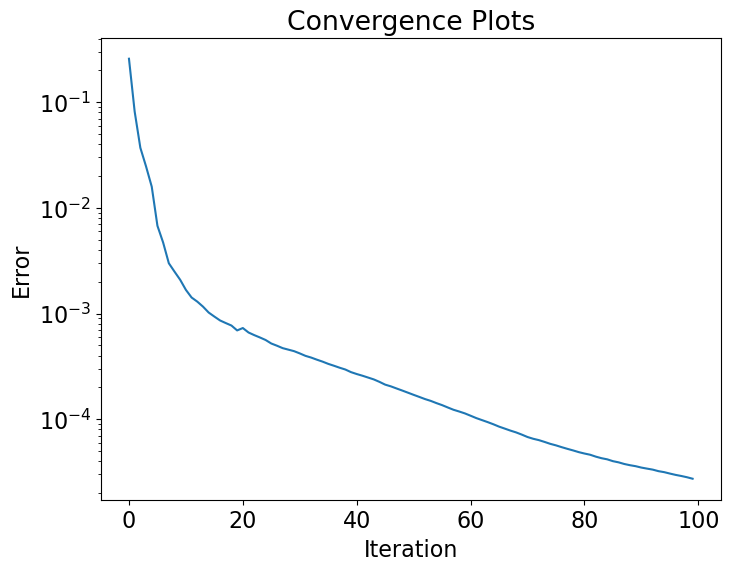

In [7]:
plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.title("Convergence Plots")
plt.show()